In [1]:
import os
import json
import random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

BASE = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT"
TRAIN_AUDIO_DIR = os.path.join(BASE, "depression_detection", "data", "train")
TEST_AUDIO_DIR  = os.path.join(BASE, "depression_detection", "data", "test")
TRAIN_CSV = os.path.join(BASE, "train_split_Depression_AVEC2017.csv")
FEATURE_DIR = os.path.join(BASE, "depression_detection", "features")
MODEL_DIR = os.path.join(BASE, "depression_detection", "models")
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


DEVICE: cpu


In [2]:
SR = 16000
WINDOW_SEC = 5.0
HOP_SEC = 2.5
N_MELS = 64
N_FFT = 1024
HOP_LEN = 256

BATCH_SIZE = 16
EPOCHS = 15
PATIENCE = 6
SEED = 42

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
set_seed()

# Mel spectrogram extraction (pure mel, non-log)
def extract_mel(y, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                         n_mels=n_mels, power=2.0)
    # No log scaling here for pure mel spectrogram
    return mel.astype(np.float32)


In [3]:
def process_file_to_windows(wav_path, out_dir, window_sec=WINDOW_SEC, hop_sec=HOP_SEC, sr=SR):
    y, _ = librosa.load(wav_path, sr=sr)
    total = len(y)
    window_samples = int(window_sec * sr)
    hop_samples = int(hop_sec * sr)
    starts = list(range(0, max(1, total - window_samples + 1), hop_samples))
    if starts and (starts[-1] + window_samples < total):
        starts.append(total - window_samples)
    if not starts:
        starts = [0]
    saved = []
    for i, s in enumerate(starts):
        chunk = y[s:s+window_samples]
        mel = extract_mel(chunk, sr=sr)
        base = Path(wav_path).stem
        fname = f"{base}_win{i}.npy"
        out_path = os.path.join(out_dir, fname)
        np.save(out_path, mel)
        saved.append(out_path)
    return saved

def preprocess_all_train(train_csv=TRAIN_CSV, audio_dir=TRAIN_AUDIO_DIR, feature_dir=FEATURE_DIR):
    df = pd.read_csv(train_csv)
    mapping = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocess train"):
        pid = str(int(row['Participant_ID']))
        wav_name = f"{pid}_AUDIO.wav"
        wav_path = os.path.join(audio_dir, wav_name)
        if not os.path.exists(wav_path):
            print("Missing:", wav_path)
            continue
        saved = process_file_to_windows(wav_path, feature_dir)
        for p in saved:
            mapping.append({"file": p, "participant": pid, "label": int(row["PHQ8_Binary"])})
    with open(os.path.join(feature_dir, "mapping.json"), "w") as f:
        json.dump(mapping, f)
    print("Total windows saved:", len(mapping))
    return mapping

mapping_path = os.path.join(FEATURE_DIR, "mapping.json")
if not os.path.exists(mapping_path):
    preprocess_all_train()
else:
    print("Mapping exists:", mapping_path)


Mapping exists: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\features\mapping.json


In [4]:
with open(mapping_path, "r") as f:
    mapping = json.load(f)
print("Total windows:", len(mapping))

class WindowDataset(Dataset):
    def __init__(self, mapping, max_frames=None):
        self.mapping = mapping
        self.max_frames = max_frames or self._compute_max_frames()
    def _compute_max_frames(self):
        maxf = 0
        for entry in self.mapping:
            arr = np.load(entry["file"])
            maxf = max(maxf, arr.shape[1])
        return maxf
    def __len__(self):
        return len(self.mapping)
    def __getitem__(self, idx):
        entry = self.mapping[idx]
        arr = np.load(entry["file"])
        n_mels, frames = arr.shape
        mf = self.max_frames
        if frames < mf:
            arr = np.pad(arr, ((0,0),(0,mf-frames)), mode='constant')
        elif frames > mf:
            arr = arr[:, :mf]
        x = torch.tensor(arr, dtype=torch.float).unsqueeze(0)  # (1, n_mels, max_frames)
        y = torch.tensor(entry["label"], dtype=torch.float)
        return x, y

dataset = WindowDataset(mapping)
df_map = pd.DataFrame(mapping)
participants = df_map['participant'].unique()
part_labels = df_map.groupby('participant')['label'].first().astype(int)
train_parts, val_parts = train_test_split(participants, test_size=0.2,
                                          random_state=SEED,
                                          stratify=[part_labels.get(p,0) for p in participants])

train_idx = df_map[df_map['participant'].isin(train_parts)].index.tolist()
val_idx   = df_map[df_map['participant'].isin(val_parts)].index.tolist()

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train windows:", len(train_ds), "Val windows:", len(val_ds))


Total windows: 38682
Train windows: 30789 Val windows: 7893


In [5]:
class ConvEncoder(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

class CNNBiLSTM(nn.Module):
    def __init__(self, n_mels=N_MELS, lstm_hidden=128, n_layers=1):
        super().__init__()
        self.encoder = ConvEncoder()
        self.lstm_hidden = lstm_hidden
        self.lstm = None
        self.classifier = nn.Sequential(
            nn.Linear(2*lstm_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        b,c,h,w = x.shape
        feat = self.encoder(x)
        b,c2,h2,w2 = feat.shape
        feat = feat.permute(0,3,1,2).contiguous().view(b, w2, -1)
        if self.lstm is None:
            input_size = feat.shape[-1]
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.lstm_hidden,
                                num_layers=1, batch_first=True, bidirectional=True).to(DEVICE)
        out, _ = self.lstm(feat)
        out = out[:, -1, :]
        logits = self.classifier(out).squeeze(1)
        return logits

model = CNNBiLSTM().to(DEVICE)
print(model)


CNNBiLSTM(
  (encoder): ConvEncoder(
    (net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_

In [6]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print("Testing first few batches for DataLoader...")
for i, (xb, yb) in enumerate(train_loader):
    print(f"Read batch {i}: x={xb.shape} y={yb.shape}")
    if i >= 2:
        break
print("Batch test done.")


Testing first few batches for DataLoader...
Read batch 0: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Read batch 1: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Read batch 2: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Batch test done.


In [7]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

best_val = float('inf')
pat = 0
train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Train E{epoch}"):
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend(probs.tolist())
            trues.extend(yb.cpu().numpy().tolist())
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_pred = [1 if p > 0.5 else 0 for p in preds]
    val_acc = accuracy_score(trues, val_pred)
    val_f1 = f1_score(trues, val_pred, zero_division=0)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        pat = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_cnn_bilstm_mel.pth"))
        print("Saved best model.")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping")
            break

print("Training completed.")



Epoch 1/15


Train E1:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5816 val_loss=0.5765 acc=0.7141 f1=0.0400
Saved best model.

Epoch 2/15


Train E2:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5152 val_loss=0.6061 acc=0.7200 f1=0.1845

Epoch 3/15


Train E3:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4326 val_loss=0.7098 acc=0.6831 f1=0.3485

Epoch 4/15


Train E4:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3735 val_loss=0.7458 acc=0.7195 f1=0.2858

Epoch 5/15


Train E5:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3336 val_loss=0.8456 acc=0.6520 f1=0.3347

Epoch 6/15


Train E6:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2999 val_loss=0.9589 acc=0.6710 f1=0.2355

Epoch 7/15


Train E7:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 7: train_loss=0.2765 val_loss=0.8599 acc=0.6952 f1=0.3997
Early stopping
Training completed.


In [8]:
import librosa
import torch

def extract_mel_for_inference(audio, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                         n_mels=n_mels, power=2.0)
    return torch.tensor(mel, dtype=torch.float).unsqueeze(0).unsqueeze(0)  # shape (1, 1, n_mels, frames)

def predict_audio(model, file_path):
    model.eval()
    audio, sr = librosa.load(file_path, sr=SR)
    features = extract_mel_for_inference(audio)
    features = features.to(DEVICE)
    with torch.no_grad():
        logits = model(features)
        prob = torch.sigmoid(logits).item()
        label = "Depressed 😔" if prob > 0.5 else "Not Depressed 🙂"
    print(f"Prediction: {label}  |  Confidence: {prob:.3f}")

# Example usage
test_audio = os.path.join(TRAIN_AUDIO_DIR, "303_AUDIO.wav")
predict_audio(model, test_audio)


Prediction: Not Depressed 🙂  |  Confidence: 0.163


In [10]:
import sounddevice as sd
import numpy as np
import torch
import librosa

def record_audio(duration_sec=5, sr=SR):
    print(f"🎙️ Recording {duration_sec} seconds of audio...")
    audio = sd.rec(int(duration_sec * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("✅ Recording complete.")
    return audio.flatten()

def extract_mel_for_inference(y, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                         n_mels=n_mels, power=2.0)
    # No log scaling, pure Mel spectrogram as in training
    mel = mel.astype(np.float32)
    return torch.tensor(mel).unsqueeze(0).unsqueeze(0)  # (1, 1, n_mels, frames)

def predict_live_audio(duration_sec=5):
    y = record_audio(duration_sec)
    y = y / (np.max(np.abs(y)) + 1e-9)  # Normalize audio amplitude
    mel = extract_mel_for_inference(y)
    mel = mel.to(DEVICE)
    model.eval()
    with torch.no_grad():
        logits = model(mel)
        prob = torch.sigmoid(logits).item()
    label = "Depressed 😔" if prob > 0.5 else "Not Depressed 🙂"
    print(f"🎧 Live Prediction: {label} | Confidence: {prob:.3f}")

# Run live prediction once
predict_live_audio(duration_sec=5)


🎙️ Recording 5 seconds of audio...
✅ Recording complete.
🎧 Live Prediction: Depressed 😔 | Confidence: 0.942


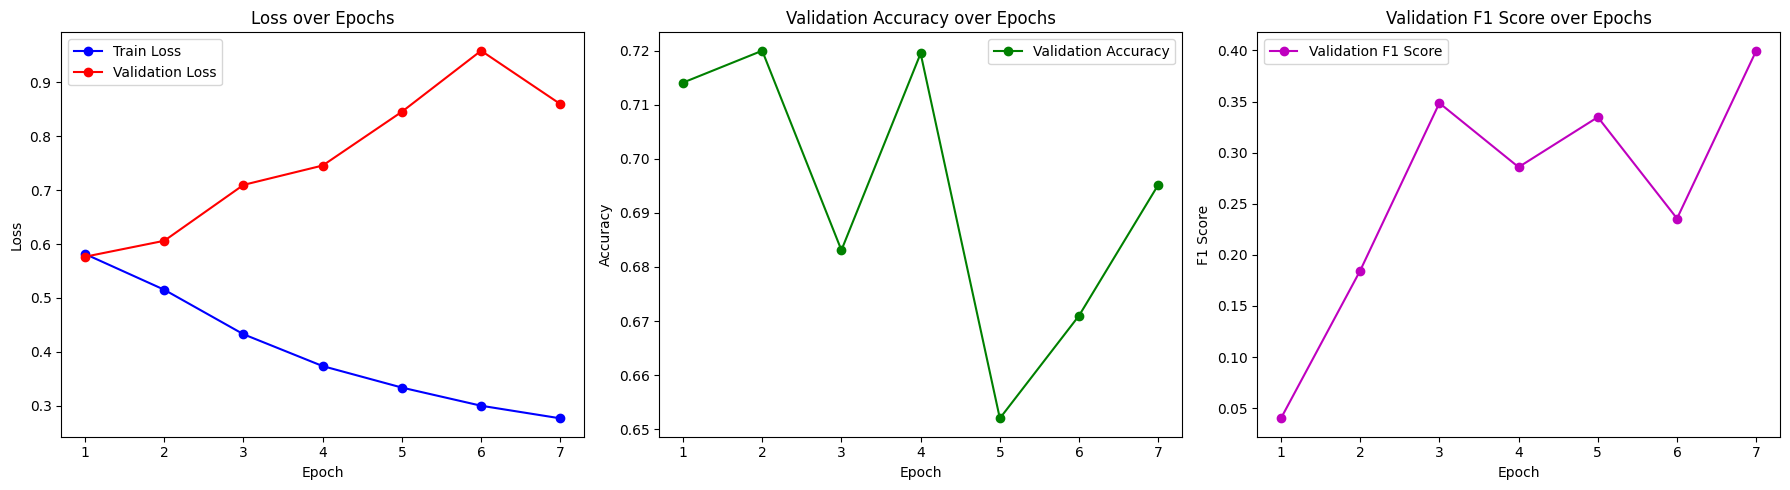

In [14]:
import matplotlib.pyplot as plt

# Your recorded values from the output logs for illustration
train_losses = [0.5816, 0.5152, 0.4326, 0.3735, 0.3336, 0.2999, 0.2765]
val_losses = [0.5765, 0.6061, 0.7098, 0.7458, 0.8456, 0.9589, 0.8599]
val_accuracies = [0.7141, 0.7200, 0.6831, 0.7195, 0.6520, 0.6710, 0.6952]
val_f1_scores = [0.04, 0.1845, 0.3485, 0.2858, 0.3347, 0.2355, 0.3997]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1_scores, 'mo-', label='Validation F1 Score')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
